# Validating chemical parsing between ChemicalTagger, ChatGPT, and manual labelling

In [1]:
import numpy as np

from pathlib import Path
import pandas as pd
import numpy as np
import os
import sys

try:
    from synoracle import ingredients, sequence
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('c:\\Users\\d23895jm\\Desktop\\Work master 2022\\Active research Projects\\synoracle_publication\\SyntheticOracle'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle import ingredients, sequence

try:
    from synparagraph import SynParagraph
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('c:\\Users\\d23895jm\\Desktop\\Work master 2022\\Active research Projects\\synoracle-preprocessing\\synoracle'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synparagraph import SynParagraph

from tqdm.notebook import tqdm, trange

def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)

In [2]:
chemtagger_f_summary = pd.DataFrame(columns=['precision', 'recall', 'f-score', 'false positives', 'true positives', 'false negatives', 'total quantities'])
chemtagger_value_f_summary = pd.DataFrame(columns=['precision', 'recall', 'f-score', 'value_match', 'false positives', 'true positives', 'false negatives', 'total quantities'])
gpt_f_summary = pd.DataFrame(columns=['precision', 'recall', 'f-score', 'false positives', 'true positives', 'false negatives', 'total quantities'])
gpt_value_f_summary = pd.DataFrame(columns=['precision', 'recall', 'f-score', 'value_match', 'false positives', 'true positives', 'false negatives', 'total quantities'])

## Cleaning the manually parsed data

In [3]:
input_boms = Path('D:/NIST_manual_BOMs.csv')

In [4]:
manual_data = pd.read_csv(input_boms)
np.unique(manual_data['unit'].astype(str))

unit_converter = {
    'L': 'volume',
    'mL': 'volume',
    'drops': 'volume',
    'g': 'mass',
    'mg': 'mass',
    'mmol': 'other_amount',
    'nan':np.nan,
    np.nan:np.nan
}


for x, c in manual_data.iterrows():
    working_units = unit_converter[c['unit']]
    manual_data.loc[x,'Units used'] = working_units
    manual_data.loc[x, working_units] = f'{c["Amount"]} {c["unit"]}'
    
manual_data = manual_data.rename({'Chemical': 'name'}, axis=1)
manual_data[manual_data['Paper']=='s12274-014-0501-4']
test = ingredients.BillOfMaterials(
        manual_data[manual_data['Paper']=='s12274-014-0501-4']
        ).initial_bill_of_materials

 zinc hydroxide


## Handling GPT BOMS

In [5]:
gpt_sequences = pd.read_json('../test_nist_database_gpt.json')
gpt_identifier = gpt_sequences['identifier'].unique()
gpt_thing = sequence.Sequence(gpt_sequences[gpt_sequences['identifier']==gpt_identifier[1]])
all_chems = []
for x in  gpt_thing.raw_synthesis['new_chemicals']:
    try: 
        working = eval(x)
    except:
        continue
    all_chems.extend([x['name'] for x in working])
print(all_chems)
gpt_thing.extract_chemicals()
gpt_bom = gpt_thing.chemical_list.produce_bill_of_mats()
print(len(gpt_bom.bill_of_materials)/len(all_chems))

['zinc nitrate hexahydrate', '2-methylimidazole', 'DMF', '100 mL autoclave', 'chloroform', 'ZIF-8 crystals', 'filtration', 'DMF']


 100 mL autoclave
 ZIF-8 crystals
 filtration


0.5


## The comparison loop

In [6]:
source_dir = Path(r"D:\NIST-ZIF-8")

pubchem_cache = str(Path(r'C:\Users\d23895jm\Desktop\Work master 2022\Active research Projects\synoracle_publication\paper analysis\exported json files\cached_pubchem.json'))
info_cache = str(Path(r'C:\Users\d23895jm\Desktop\Work master 2022\Active research Projects\synoracle_publication\paper analysis\exported json files\cached_molecule_info.json'))

paper_indices = iter(np.unique(manual_data['Paper'].astype(str) + '.' + manual_data['Paragraph'].astype(str)))

for paper_id in paper_indices: 
    print(f'{paper_id}\n-----------------')
    ## The manual bit
    manual_parse = ingredients.BillOfMaterials(
        manual_data[(manual_data['Paper']==paper_id.split('.')[0]) & (manual_data['Paragraph']==int(paper_id.split('.')[1]))], 
        identifier_cache_location = pubchem_cache,
        property_cache_location = info_cache
        )

    ## The chemTagger bit
    test_paragraph = SynParagraph(paper_identifier=paper_id, source_directory=source_dir)
    test_sequence = sequence.Sequence(test_paragraph.raw_synthesis)
    
    test_sequence.drop_invalid_lines()
    test_sequence.extract_chemicals()

    tdm_parse = test_sequence.chemical_list.produce_bill_of_mats(
        identifier_cache_location = pubchem_cache,
        property_cache_location = info_cache
    )

    ## The GPT bit    
    gpt_thing = sequence.Sequence(gpt_sequences[gpt_sequences['identifier']==paper_id])
    gpt_thing.extract_chemicals()
    gpt_bom = gpt_thing.chemical_list.produce_bill_of_mats(
        identifier_cache_location = pubchem_cache,
        property_cache_location = info_cache)
    gpt_bom.bill_of_materials
    
    ## The comparison bit
    real_identification = set([x for x in manual_parse.bill_of_materials.index])
    test_identification = set([x for x in tdm_parse.bill_of_materials.index])
    gpt_identification = set([x for x in gpt_bom.bill_of_materials.index])

    chemtagger_true_positive = test_identification.intersection(real_identification)
    gpt_true_positive = gpt_identification.intersection(real_identification)

    chemtagger_precision = len(chemtagger_true_positive)/len(test_identification)
    chemtagger_recall = len(chemtagger_true_positive)/len(real_identification)

    try:
        gpt_precision = len(gpt_true_positive)/len(gpt_identification)
        gpt_recall = len(gpt_true_positive)/len(real_identification)
    except ZeroDivisionError:
        gpt_precision = 0
        gpt_recall = 0
    
    ## Calculating f-scores

    try:
        chemtagger_f_score = 2*chemtagger_precision*chemtagger_recall/(chemtagger_precision+chemtagger_recall)
    except ZeroDivisionError:
        chemtagger_f_score = 0

    chemtagger_f_summary.loc[paper_id] = {
        'precision': chemtagger_precision,
        'recall':chemtagger_recall,
        'f-score':chemtagger_f_score,
        'false positives': len(test_identification-real_identification),
        'true positives': len(chemtagger_true_positive),
        'false negatives': len(real_identification-test_identification),
        'total quantities': len(real_identification)
            }
    
    try:
        gpt_f_score = 2*gpt_precision*gpt_recall/(gpt_precision+gpt_recall)
    except ZeroDivisionError:
        gpt_f_score = 0
        
    gpt_f_summary.loc[paper_id] = {
        'precision': gpt_precision, 
        'recall':gpt_recall, 
        'f-score':gpt_f_score,
        'false positives': len(gpt_identification-real_identification),
        'true positives': len(gpt_true_positive),
        'false negatives': len(real_identification-gpt_identification),
        'total quantities': len(real_identification)
        }

    ## Calculating total number of specified amounts

    raw_specified_quantities = {
    x:(y is not np.nan) for x in real_identification for y in manual_parse.initial_bill_of_materials[manual_parse.initial_bill_of_materials['pubchem_id']==x]['moles'].tolist()
    }
    raw_specified_quantities = set([x for x,y in raw_specified_quantities.items() if y is not np.nan])


    tdm_specified_quantities = {
    x:(y is not np.nan) for x in chemtagger_true_positive for y in tdm_parse.initial_bill_of_materials[tdm_parse.initial_bill_of_materials['pubchem_id']==x]['moles'].tolist()
    }
    tdm_specified_quantities = set([x for x,y in tdm_specified_quantities.items() if y is not np.nan])


    gpt_specified_quantities = {
    x:(y is not np.nan) for x in gpt_true_positive for y in gpt_bom.initial_bill_of_materials[gpt_bom.initial_bill_of_materials['pubchem_id']==x]['moles'].tolist()
    }
    gpt_specified_quantities = set([x for x,y in gpt_specified_quantities.items() if y is not np.nan])


    ## Calculating matched values (Chemtagger)

    chemtagger_n_correct_values = 0


    for x in tdm_specified_quantities.intersection(raw_specified_quantities):

        manual_value = manual_parse.initial_bill_of_materials[manual_parse.initial_bill_of_materials['pubchem_id']==x].loc[:,'moles'].sum()
        tdm_value = tdm_parse.initial_bill_of_materials.loc[tdm_parse.initial_bill_of_materials['pubchem_id']==x].loc[:,'moles'].sum()

        if np.isclose(manual_value, tdm_value, rtol = 0.01) and manual_value is not np.nan:
            chemtagger_n_correct_values +=1
    
    
    if len(tdm_specified_quantities) >0:
        chemtagger_value_precision = chemtagger_n_correct_values/len(tdm_specified_quantities)
    else:
        chemtagger_value_precision = 0
    if len(raw_specified_quantities)>0:
        chemtagger_value_recall = chemtagger_n_correct_values/len(raw_specified_quantities)
    else:
        chemtagger_value_recall = 0
        

    try:
        chemtagger_value_match = chemtagger_n_correct_values/len(tdm_specified_quantities.intersection(raw_specified_quantities))
    except ZeroDivisionError:
        chemtagger_value_match = 0
    try:
        chemtagger_value_f_score = 2*chemtagger_value_precision*chemtagger_value_recall/(chemtagger_value_precision+chemtagger_value_recall)
    except ZeroDivisionError:
        chemtagger_value_f_score = 0


    chemtagger_value_f_summary.loc[paper_id] = {
        'precision': chemtagger_value_precision, 
        'recall':chemtagger_value_recall, 
        'f-score':chemtagger_value_f_score, 
        'value_match': chemtagger_value_match,
        'false positives': len(tdm_specified_quantities)-chemtagger_n_correct_values,
        'true positives': chemtagger_n_correct_values,
        'false negatives': len(raw_specified_quantities)-chemtagger_n_correct_values,
        'total quantities': len(raw_specified_quantities)
        }

    ## Calculating matched values (GPT)

    gpt_n_correct_values = 0
    gpt_n_values = 0
    manual_n_values = 0
    
    for x in gpt_specified_quantities.intersection(raw_specified_quantities):
        manual_value = manual_parse.initial_bill_of_materials[manual_parse.initial_bill_of_materials['pubchem_id']==x].loc[:,'moles'].sum()
        gpt_value = gpt_bom.initial_bill_of_materials.loc[gpt_bom.initial_bill_of_materials['pubchem_id']==x].loc[:,'moles'].sum()

        if np.isclose(manual_value, gpt_value, rtol = 0.01) and manual_value is not np.nan:
            gpt_n_correct_values +=1

    
    if len(gpt_specified_quantities)>0:
        gpt_value_precision = gpt_n_correct_values/len(gpt_specified_quantities)
    else:
        gpt_value_precision =0

    if len(raw_specified_quantities)>0:
        gpt_value_recall = gpt_n_correct_values/len(raw_specified_quantities)
    else:
        gpt_value_recall =0     


    try:
        gpt_value_match = gpt_n_correct_values/len(gpt_true_positive)
    except ZeroDivisionError:
        gpt_value_match = 0
    try:
        gpt_value_f_score = 2*gpt_value_precision*gpt_value_recall/(gpt_value_precision+gpt_value_recall)
    except ZeroDivisionError:
        gpt_value_f_score = 0


    gpt_value_f_summary.loc[paper_id] = {
        'precision': gpt_value_precision, 
        'recall':gpt_value_recall, 
        'f-score':gpt_value_f_score, 
        'value_match': gpt_value_match,
        'false positives': len(gpt_specified_quantities)-gpt_n_correct_values,
        'true positives': gpt_n_correct_values,
        'false negatives': len(raw_specified_quantities)-gpt_n_correct_values,
        'total quantities': len(raw_specified_quantities)

        }



009589722013797966.16
-----------------
Aic13970.6
-----------------
Aic13970.7
-----------------
Aic14525.0
-----------------
JPOWTEC201309013.44
-----------------
anie201104383.0
-----------------
c1ce05780d.0
-----------------
c2cc34893d.0
-----------------
c2jm15685g.24
-----------------
c3ta11483j.23
-----------------
c4ee01009d.0
-----------------
c5ra01183c.11
-----------------


ERROR:root:Error encountered converting raw info to pint unit:
----------------------
ERROR:root:amount in question: name                 GO
percent       [10 wt %]
Units used    [percent]
Name: 5, dtype: object


chem201301461.32
-----------------
cm3006953.27
-----------------


ERROR:root:Error encountered converting raw info to pint unit:
----------------------


jelectacta201411093.30
-----------------
jijhydene201510038.40
-----------------


ERROR:root:amount in question: Paper                jijhydene201510038
Paragraph                            40
name                               HNO3
Quantity provided                     1
Amount                                3
unit                              drops
molar ratio                         NaN
comment                             NaN
Units used                       volume
other_amount                        NaN
volume                          3 drops
NaN                                 NaN
mass                                NaN
Name: 59, dtype: object
ERROR:root:Error encountered converting raw info to pint unit:
----------------------
ERROR:root:amount in question: name                   HNO3
mass                    NaN
volume        [three drops]
Units used         [volume]
Name: 3, dtype: object


jmemsci201411038.43
-----------------
jmemsci201505015.55
-----------------
jmemsci201505015.56
-----------------
jmicromeso201203052.34
-----------------
jmicromeso201211012.32
-----------------
jmicromeso201211012.33
-----------------
jp407792a.25
-----------------
jp407792a.26
-----------------
jp5081466.1
-----------------
jp5081466.10
-----------------
jp5081466.2
-----------------
jp5081466.3
-----------------
jp5081466.4
-----------------
jp5081466.5
-----------------
jp5081466.6
-----------------
jp5081466.7
-----------------
jp5081466.8
-----------------
jp5081466.9
-----------------
jssc201406017.48
-----------------
jultsonch201704030.47
-----------------
jz300855a.1
-----------------
jz300855a.2
-----------------
jz300855a.3
-----------------
la401471g.31
-----------------


ERROR:root:Error encountered converting raw info to pint unit:
----------------------
ERROR:root:amount in question: name                     HMeIM
mass                 [0.552 g]
other_amount        [10-3 mol]
volume                     NaN
Units used      [other_amount]
Name: 0, dtype: object
ERROR:root:Error encountered converting raw info to pint unit:
----------------------
ERROR:root:amount in question: name            zinc nitrate hexahydrate
mass                               [1 g]
other_amount                  [10-3 mol]
volume                               NaN
Units used                [other_amount]
Name: 3, dtype: object


s10450-012-9407-1.18
-----------------
s12274-014-0501-4.0
-----------------
s1872-2067(14)60292-8.30
-----------------


## Chemical entity recognition

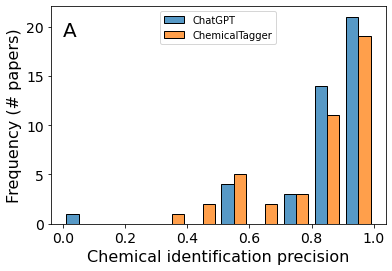

Chemical identification precision:
---------------------------------------
Chemtagger average:  82.4 % +/-  19.7 %
GPT average:         85.5 % +/-  19.6 %


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  gpt_f_summary['precision'], 'ChemTagger':chemtagger_f_summary['precision'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Chemical identification precision', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('A', (0,19),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Chemical identification precision:\n---------------------------------------')
print(f"Chemtagger average: {round(100*chemtagger_f_summary['precision'].mean(),1):>5} % +/- {round(100*chemtagger_f_summary['precision'].std(),1):>5} %")
print(f"GPT average: {round(100*gpt_f_summary['precision'].mean(),1):>12} % +/- {round(100*gpt_f_summary['precision'].std(),1):>5} %")

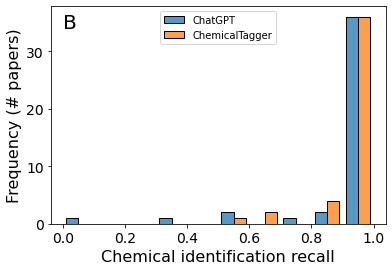

Chemical identification recall:
---------------------------------------
Chemtagger average:  95.5 % +/-  11.3 %
GPT average:         92.3 % +/-  20.9 %


In [23]:
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  gpt_f_summary['recall'], 'ChemTagger':chemtagger_f_summary['recall'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Chemical identification recall', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('B', (0,34),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Chemical identification recall:\n---------------------------------------')
print(f"Chemtagger average: {round(100*chemtagger_f_summary['recall'].mean(),1):>5} % +/- {round(100*chemtagger_f_summary['recall'].std(),1):>5} %")
print(f"GPT average: {round(100*gpt_f_summary['recall'].mean(),1):>12} % +/- {round(100*gpt_f_summary['recall'].std(),1):>5} %")

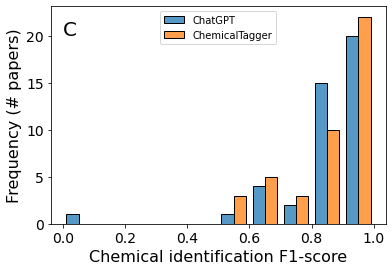

Chemical identification F1-score:
---------------------------------------
Chemtagger average:  86.9 % +/-  14.7 %
GPT average:         87.0 % +/-  18.1 %


In [25]:
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  gpt_f_summary['f-score'], 'ChemTagger':chemtagger_f_summary['f-score'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Chemical identification F1-score', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('C', (0,20),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Chemical identification F1-score:\n---------------------------------------')
print(f"Chemtagger average: {round(100*chemtagger_f_summary['f-score'].mean(),1):>5} % +/- {round(100*chemtagger_f_summary['f-score'].std(),1):>5} %")
print(f"GPT average: {round(100*gpt_f_summary['f-score'].mean(),1):>12} % +/- {round(100*gpt_f_summary['f-score'].std(),1):>5} %")


## Chemical quantity matching

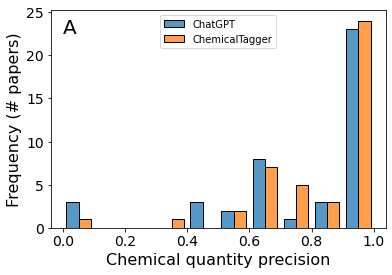

Chemical quantity matching precision:
---------------------------------------
Chemtagger average:  84.1 % +/-  22.2 %
GPT average:         78.4 % +/-  29.4 %


In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  gpt_value_f_summary['precision'], 'ChemTagger':chemtagger_value_f_summary['precision'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Chemical quantity precision', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('A', (0,22.5),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Chemical quantity matching precision:\n---------------------------------------')
print(f"Chemtagger average: {round(100*chemtagger_value_f_summary['precision'].mean(),1):>5} % +/- {round(100*chemtagger_value_f_summary['precision'].std(),1):>5} %")
print(f"GPT average: {round(100*gpt_value_f_summary['precision'].mean(),1):>12} % +/- {round(100*gpt_value_f_summary['precision'].std(),1):>5} %")

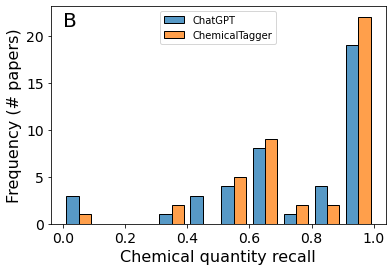

Chemical quantity matching recall:
---------------------------------------
Chemtagger average:  80.4 % +/-  24.0 %
GPT average:         74.3 % +/-  29.7 %


In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  gpt_value_f_summary['recall'], 'ChemTagger':chemtagger_value_f_summary['recall'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Chemical quantity recall', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('B', (0,21),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Chemical quantity matching recall:\n---------------------------------------')
print(f"Chemtagger average: {round(100*chemtagger_value_f_summary['recall'].mean(),1):>5} % +/- {round(100*chemtagger_value_f_summary['recall'].std(),1):>5} %")
print(f"GPT average: {round(100*gpt_value_f_summary['recall'].mean(),1):>12} % +/- {round(100*gpt_value_f_summary['recall'].std(),1):>5} %")

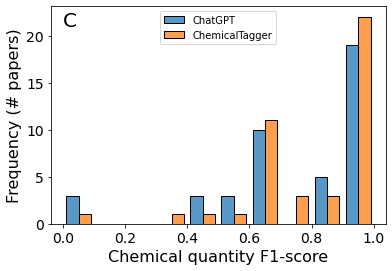

Chemical quantity matching F1-score:
---------------------------------------
Chemtagger average:  81.8 % +/-  22.8 %
GPT average:         75.7 % +/-  29.0 %


In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  gpt_value_f_summary['f-score'], 'ChemTagger':chemtagger_value_f_summary['f-score'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Chemical quantity F1-score', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('C', (0,21),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Chemical quantity matching F1-score:\n---------------------------------------')
print(f"Chemtagger average: {round(100*chemtagger_value_f_summary['f-score'].mean(),1):>5} % +/- {round(100*chemtagger_value_f_summary['f-score'].std(),1):>5} %")
print(f"GPT average: {round(100*gpt_value_f_summary['f-score'].mean(),1):>12} % +/- {round(100*gpt_value_f_summary['f-score'].std(),1):>5} %")